# 03_ResNet50

### (6) 사용하는 전이학습 방법(모델 및 사용법)의 구체적 설명 + 딥네트웍 구조 도식화 및 설명

🔹 전이학습 개요

ResNet50은 50개의 층으로 구성된 Residual Network로, 이미지 분류에서 널리 사용되는 고성능 딥러닝 모델입니다. 본 프로젝트에서는 ImageNet 사전학습 가중치를 이용한 전이학습(transfer learning)을 통해 적은 양의 데이터로도 높은 성능을 도출하고자 하였습니다.

🔹 사용 방식

weights='imagenet': ImageNet 데이터셋으로 학습된 가중치를 불러와 기본 특징 추출기로 사용

include_top=False: 원래의 FC(fully connected) 층을 제거하고, 새로 분류기를 구성

trainable=False: 기존 가중치를 고정하여 feature extractor 역할만 수행

🔹 전체 모델 구조


```
[입력 이미지 (224, 224, 3)]
        ↓
[ResNet50 (include_top=False)]
        ↓
[GlobalAveragePooling2D]
        ↓
[Dense(128, relu)]
        ↓
[Dense(3, softmax)]  ← 3개의 칼 종류 분류
```

🔹 도식 설명

ResNet50: CNN 기반으로 깊은 층에도 학습이 가능하도록 skip connection 구조를 갖는 특징 추출기

GlobalAveragePooling2D: feature map을 flatten 하지 않고 평균값으로 압축하여 과적합 감소

Dense(128, ReLU): 은닉층을 추가하여 비선형성을 확보

Dense(3, softmax): 최종 출력층, 3개의 칼 클래스(식칼, 과도, 커터칼)를 분류

In [ ]:
# 한글 폰트 설치 (나눔체) - 시각화 시 用

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,946 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and dire

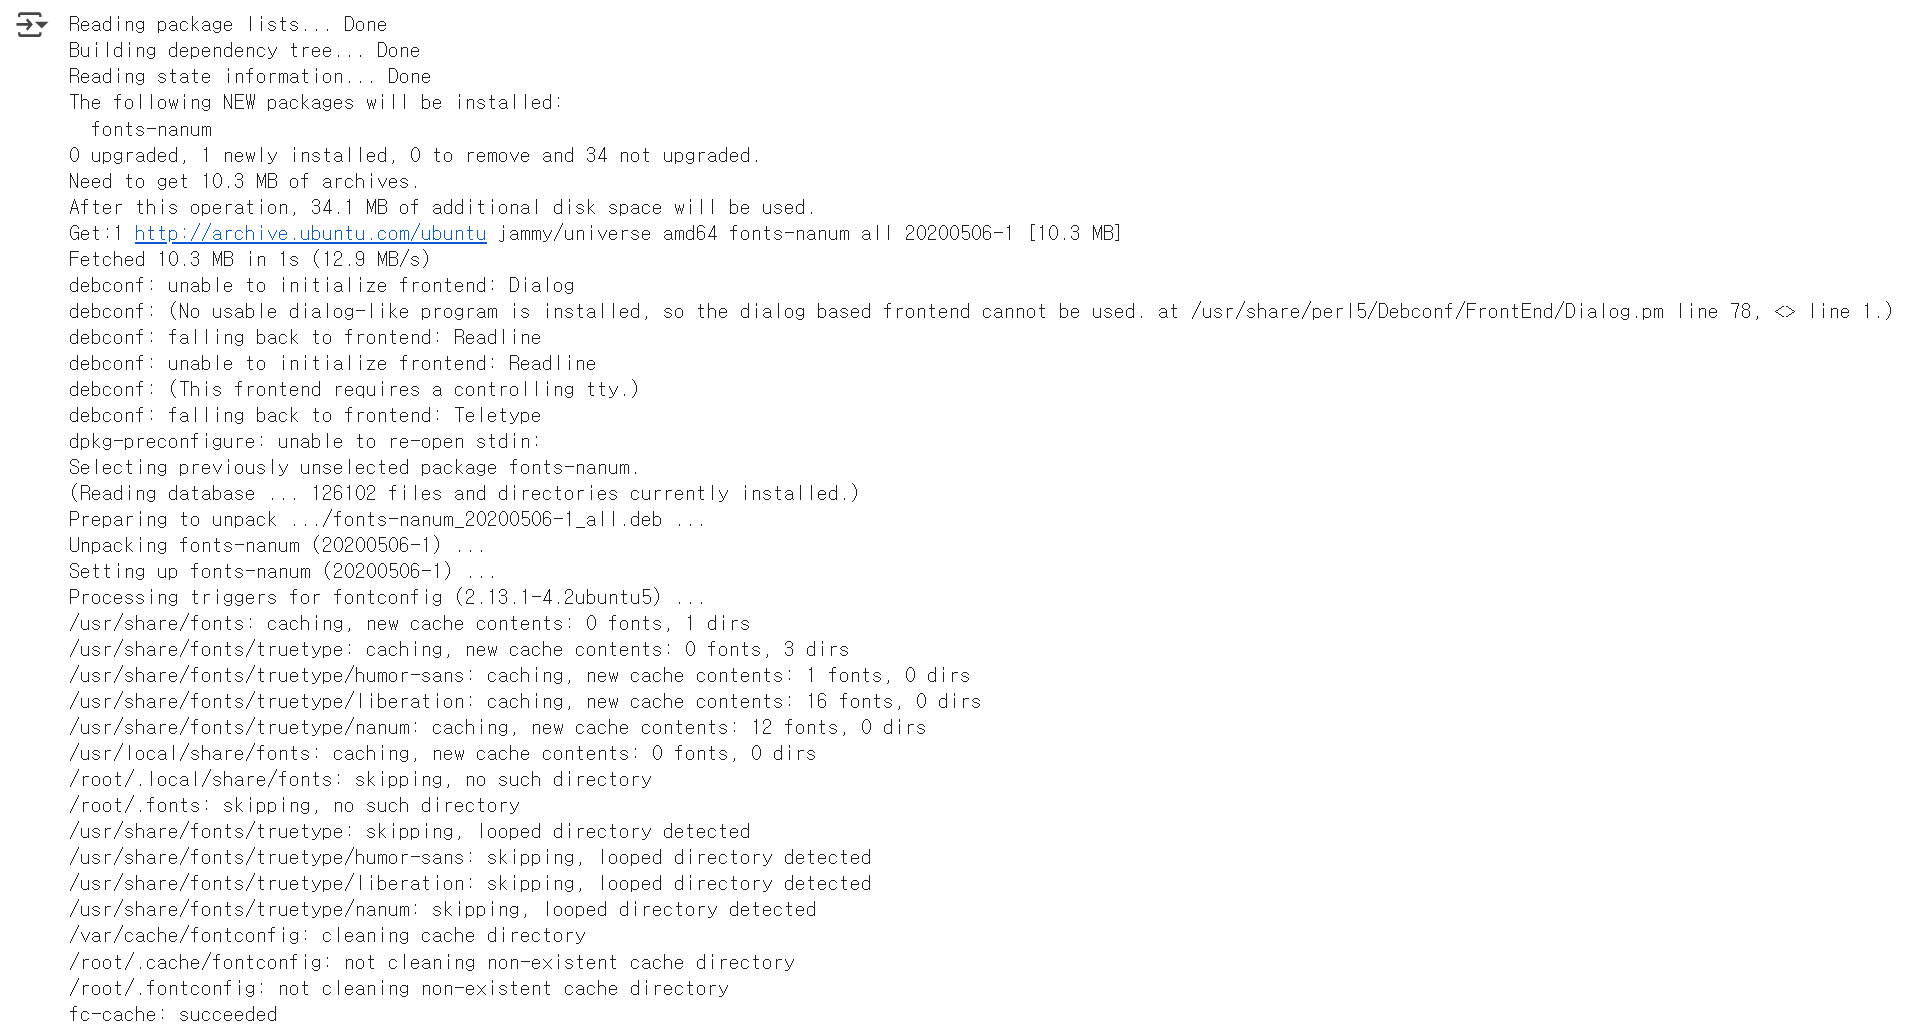

In [ ]:
# Github에서 데이터 불러온 후 zip파일 압축 해제

!wget https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
!unzip -q knives_dataset.zip

--2025-06-01 13:54:05--  https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip [following]
--2025-06-01 13:54:06--  https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12307377 (12M) [application/zip]
Saving to: ‘knives_dataset.zip’

knives_dataset.zip  100%[===================>]  11.74M  30.6MB/s    in 0.4s    

2025-06-01 13:54:07 (30.6 MB/s) - ‘knives_dataset.zip’ saved [12307377/12307

In [ ]:
# 메타데이터 생성

import os
import pandas as pd

origin = '/content/knives_dataset'
data = []

for folder in os.listdir(origin):
    folder_path = os.path.join(origin, folder)
    if not os.path.isdir(folder_path):
        continue

    parts = folder.split('_')
    if len(parts) != 5:
        continue

    번호, 조도, 배경, 칼종류, 오클루전 = parts

    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.png')):
            data.append({
                '파일명': file,
                '폴더명': folder,
                '조도': 조도,
                '배경': 배경,
                '칼종류': 칼종류,
                '오클루전': 오클루전,
                '전체경로': os.path.join(folder_path, file)
            })

df_meta = pd.DataFrame(data)


In [ ]:
# 메타데이터 생성 여부 확인

df_meta['칼종류'].value_counts()

,count
칼종류,
과도,240
식칼,187
커터칼,156


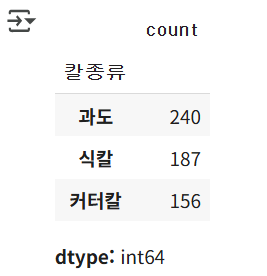

In [ ]:
# 칼 종류별(식칼, 과도, 커터칼) 정리된 폴더 구조 생성

import os
import shutil

origin = '/content/knives_dataset'
base_dir = '/content/knife_class_dataset'
classes = ['식칼', '과도', '커터칼']
os.makedirs(base_dir, exist_ok=True)

for folder in os.listdir(origin):
    for c in classes:
        if c in folder:
            target_dir = os.path.join(base_dir, c)
            os.makedirs(target_dir, exist_ok=True)
            for file in os.listdir(os.path.join(origin, folder)):
                src = os.path.join(origin, folder, file)
                dst = os.path.join(target_dir, file)
                shutil.copy(src, dst)


In [ ]:
# ImageDataGenerator로 칼 종류 기준 분류 학습용 데이터 구성

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 309 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


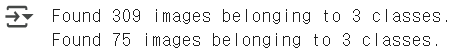

## ResNet50 학습 코드

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers, optimizers

# 1. ResNet50 base model (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 전이학습 - feature extractor로만 사용

# 2. 전체 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 클래스 수: 3개 (식칼, 과도, 커터칼)
])

# 3. 컴파일
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. 학습
history_resnet = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3387 - loss: 1.2954 - val_accuracy: 0.2800 - val_loss: 1.1041
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3486 - loss: 1.1347 - val_accuracy: 0.2800 - val_loss: 1.1274
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.3462 - loss: 1.1061 - val_accuracy: 0.4000 - val_loss: 1.0798
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4634 - loss: 1.0816 - val_accuracy: 0.6800 - val_loss: 1.0215
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5567 - loss: 1.0341 - val_accuracy: 0.4800 - val_loss: 1.0489
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.4181 - loss: 1.0611 - val_accuracy: 0.3600 - val_loss: 1.0383
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.4288 - loss: 1.0425 - val_accuracy: 0.6400 - val_loss: 1.0004
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4151 - loss: 1.0238 - val_accuracy: 0.6800 - val_lo

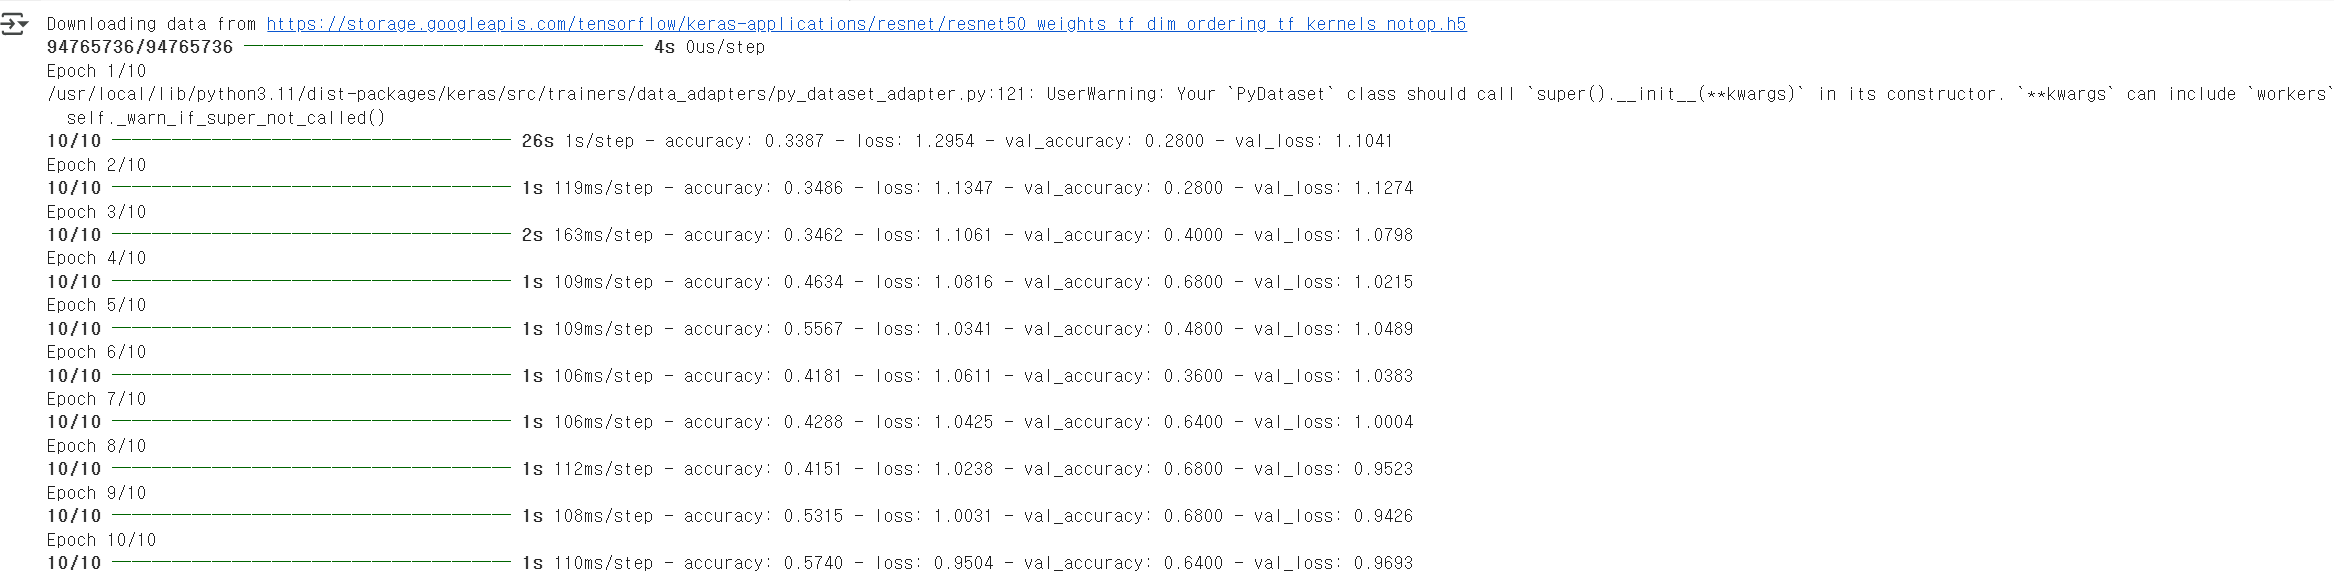

### ResNet50 학습 결과 요약
- 학습 기간: 총 10 epoch

- 초기 성능:

  - Epoch 1에서 훈련 정확도 33.9%, 검증 정확도 28.0%로 시작

  - 손실도 매우 높음 (train: 1.2954 / val: 1.1041)

- 학습 진행 중 변화:

  - Epoch 3부터 점차 성능 향상,

  - Epoch 4에서 검증 정확도 급상승 (68.0%), 이후 변동 있음

  - Epoch 6-10까지 검증 정확도는 64-68% 사이 유지, 학습 정확도는 지속적으로 상승

- 최종 성능:

  - 훈련 정확도: 57.40%

  - 검증 정확도: 64.00%

  - 손실도 점진적으로 감소했지만, 성능 향상 폭은 제한적

- 특이사항:

  - Epoch 5~6에서 훈련/검증 성능 모두 일시적 저하 → 데이터 불균형 또는 일반화 부족 가능성

  - 검증 정확도가 일정 수준 이상에서 정체되는 현상 보임 → 추가 미세조정(fine-tuning) 필요

In [ ]:
# 검증셋 예측값 저장

import numpy as np

val_gen.reset()
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 파일 경로 목록도 저장
filenames = val_gen.filenames


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


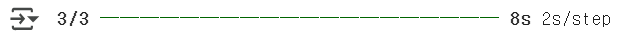

In [ ]:
# 예측 결과 DataFrame 만들기

import pandas as pd

df_pred = pd.DataFrame({
    '파일경로': filenames,
    '실제클래스': [class_labels[i] for i in true_classes],
    '예측클래스': [class_labels[i] for i in pred_classes]
})


In [ ]:
# df_meta와 merge (조건 붙이기)

# 파일명 컬럼 생성
df_pred['파일명'] = df_pred['파일경로'].apply(lambda x: x.split('/')[-1])

# df_meta에서 '파일명' 기준으로 merge
df_merged = pd.merge(df_pred, df_meta, on='파일명', how='left')


In [ ]:
# ✅ 조건별 정확도 분석

# 조도별 정확도
조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("✅ 조도별 정확도:\n", 조도별정확도)

# 오클루전 여부별 정확도
오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 오클루전 여부별 정확도:\n", 오클루전정확도)

# 배경별 정확도
배경별정확도 = df_merged.groupby('배경').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 배경별 정확도:\n", 배경별정확도)

# 칼 종류별 정확도 (촬영된 칼 종류 기준)
칼종류정확도 = df_merged.groupby('칼종류').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 칼 종류별 정확도 (촬영 기준):\n", 칼종류정확도)

# 폴더명 기준 정확도 (영상 단위 분석)
폴더별정확도 = df_merged.groupby('폴더명').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 폴더별 정확도 (전체 조건 조합):\n", 폴더별정확도)


✅ 조도별 정확도:
 조도
bright    0.238710
dark      0.182741
dtype: float64

✅ 오클루전 여부별 정확도:
 오클루전
none    0.210227
yes     0.204545
dtype: float64

✅ 배경별 정확도:
 배경
desk          0.222222
floor         0.234848
kitchen       0.128440
livingroom    0.184211
window        0.700000
dtype: float64

✅ 칼 종류별 정확도 (촬영 기준):
 칼종류
과도     0.118227
식칼     0.228070
커터칼    0.657143
dtype: float64

✅ 폴더별 정확도 (전체 조건 조합):
 폴더명
knife01_bright_kitchen_식칼_none      0.104167
knife02_dark_desk_과도_none           0.127660
knife04_bright_floor_식칼_none        0.555556
knife05_dark_kitchen_과도_yes         0.113636
knife06_bright_window_커터칼_none      0.625000
knife07_bright_desk_식칼_yes          0.000000
knife08_dark_livingroom_커터칼_none    0.666667
knife09_dark_floor_커터칼_yes          0.611111
knife10_dark_window_커터칼_yes         1.000000
knife12_dark_kitchen_커터칼_none       1.000000
knife13_bright_window_커터칼_yes       1.000000
knife14_dark_floor_과도_yes           0.104167
knife15_bright_kitchen_과도_none      0.187500
knife16_bri

<ipython-input-10-65d8591a3c9e>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-10-65d8591a3c9e>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-10-65d8591a3c9e>:12: DeprecationWarning: DataFrameGroupBy.appl

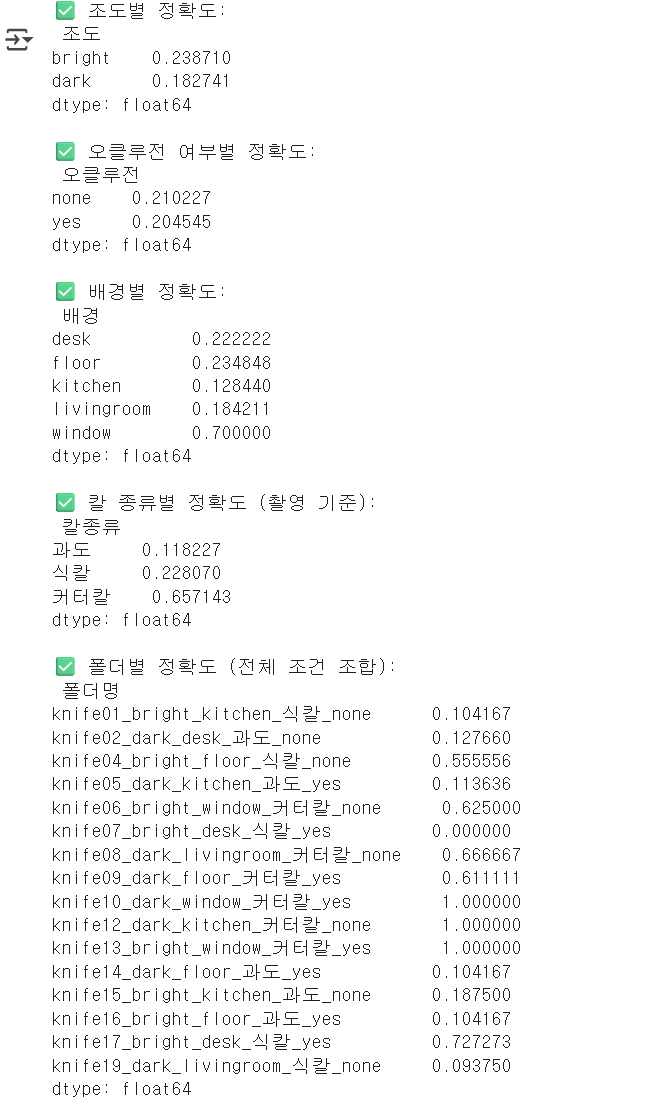



## ResNet50 조건별 정확도 분석 요약

####  1. **조도별 성능**

* **bright**: 23.87%
* **dark**: 18.27%
  → **밝은 환경에서 약간 더 좋은 성능**, 어두운 조도에서는 성능이 더 크게 저하됨 → **조도 민감도 존재**

---

####  2. **오클루전(가림 여부)**

* **none**: 21.02%
* **yes**: 20.45%
  → 오클루전 여부에 따른 **성능 차이는 거의 없음**, 모델이 가림 요소 자체에는 큰 영향을 받지 않음

---

#### 3. **배경별 성능**

| 배경         | 정확도              |
| ---------- | ---------------- |
| window     | **70.00%** ✅ 최고  |
| floor      | 23.48%           |
| desk       | 22.22%           |
| livingroom | 18.42%           |
| kitchen    | **12.84%** 🔻 최저 |

→ **window 배경에서 매우 뛰어난 성능**, 반면 **kitchen에서는 극단적으로 낮은 성능** → 배경의 영향력 큼

---

#### 4. **칼 종류별 정확도 (촬영 기준)**

| 칼 종류 | 정확도                 |
| ---- | ------------------- |
| 커터칼  | **65.71%** ✅ 매우 높음  |
| 식칼   | 22.81%              |
| 과도   | **11.82%** 🔻 매우 낮음 |

→ **커터칼만 유독 높은 인식률**, 반면 **과도는 거의 분류하지 못하는 수준** → 클래스 불균형 또는 형태 구분 어려움 가능성

---

#### 5. **폴더별 성능 (조건 조합별)**

→ 조건 조합에 따라 **극단적인 성능 분포**

* **최고 정확도**:

  * `knife10_dark_window_커터칼_yes` → **100%**
  * `knife12_dark_kitchen_커터칼_none` → **100%**
  * `knife13_bright_window_커터칼_yes` → **100%**
  * `knife17_bright_desk_식칼_yes` → **72.73%**
* **최저 정확도**:

  * `knife07_bright_desk_식칼_yes` → **0.00%**
  * `knife19_dark_livingroom_식칼_none` → **9.38%**

→ **조건 조합별 편차가 매우 큼**, 특히 **커터칼+window 조합에서만 강세**를 보이는 **편향된 인식 특성** 존재

---

**한 줄 요약** :
ResNet50은 전반적으로 정확도가 낮고, 특정 조건(커터칼 + window 배경)에만 성능이 집중되는 **편향된 경향**을 보였으며, **과도와 일부 배경에서는 거의 인식하지 못하는 한계를 드러냈다.**


# 모델 학습 결과 시각화


## (1) ResNet50 학습 및 검증 정확도 변화 (Accuracy Plot)

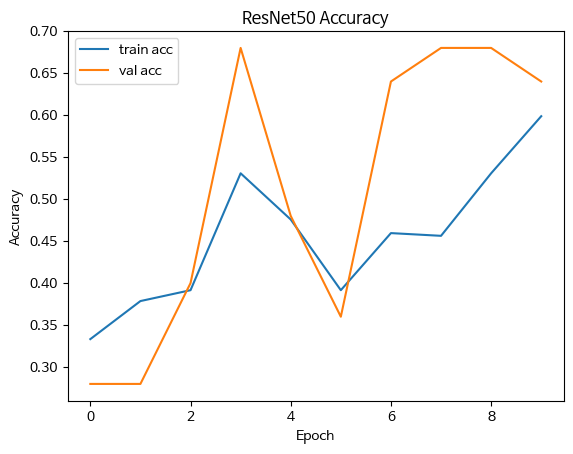

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

plt.plot(history_resnet.history['accuracy'], label='train acc')
plt.plot(history_resnet.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy')
plt.legend()
plt.show()


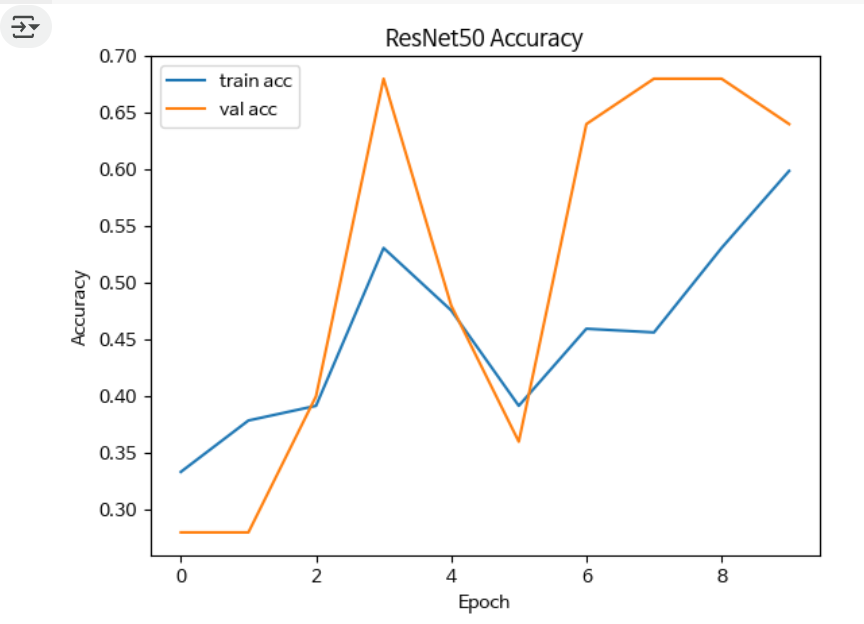


## Accuracy Plot 해석 요약
1) 전반적 특징

- 훈련 정확도는 전체적으로 완만하게 상승했으며, Epoch 9 기준 약 60% 도달

- 검증 정확도는 초반 급상승 이후 큰 진폭을 보이며 등락을 반복함

- 후반에는 64~68% 수준에서 정체되는 경향을 보임

2) 세부 분석

(1) 초기 Epoch (0~2)

- 검증 정확도는 Epoch 2~3 사이 급격히 상승(28% → 68%)

- 이는 모델이 빠르게 일부 특징을 학습하여 초기 일반화 능력을 발휘한 것으로 해석

(2) 중반 Epoch (3~5)

- 검증 정확도가 급락(68% → 36%)하는 등 불안정한 진폭 발생

- 훈련 정확도 또한 일시적으로 하락 → 과도한 학습률, 데이터 셔플링, 배치 간 편차 가능성

(3) 후반 Epoch (6~9)

- 검증 정확도는 64~68%에서 반복되며 정체 상태 유지

- 훈련 정확도는 서서히 상승해 60% 근처까지 도달

→ 일정 수준에서 일반화 성능이 한계에 도달한 양상

3) 한 줄 요약

ResNet50은 초기에는 빠르게 검증 정확도가 상승했지만, 이후 진폭이 크고 불안정한 학습을 보였으며, 후반에는 성능이 정체되며 전이학습 효과가 충분히 발휘되지 않은 제한적인 결과를 보였다.

# (2) ResNet50의 클래스별 예측 정확도 (Confusion Matrix)

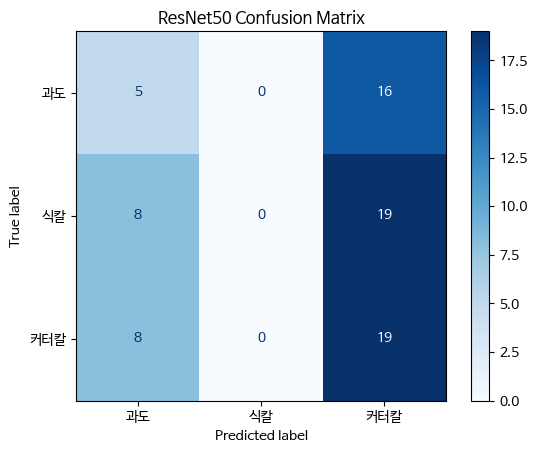

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rc('font', family='NanumBarunGothic')

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("ResNet50 Confusion Matrix")
plt.show()


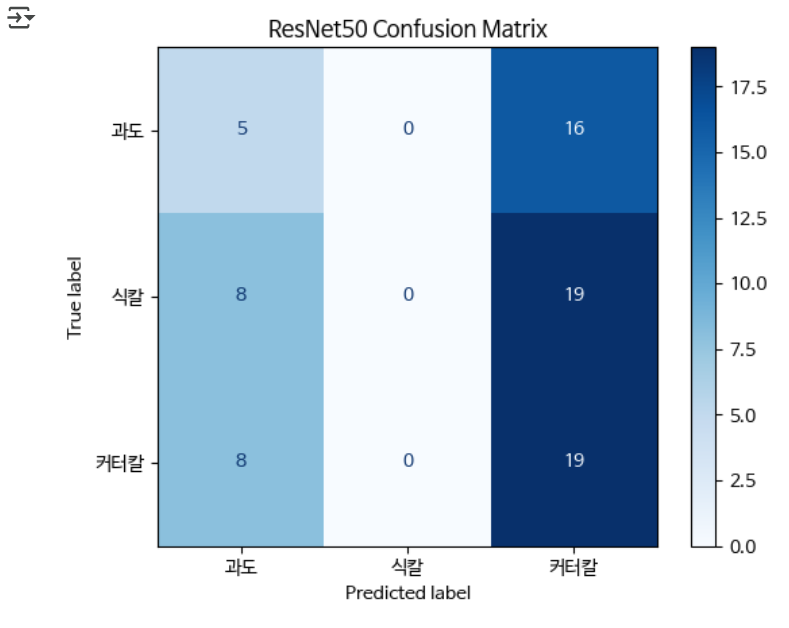


## Confusion Matrix 해석 요약
1) 전반적 특징

- 모든 클래스가 커터칼로 예측되는 편향을 보임

- 특히 식칼은 단 한 건도 정답으로 맞추지 못함 (식칼 열이 전부 0)

- 과도와 커터칼 간 오분류도 다수 존재, 전체적으로 커터칼에 치우친 예측 경향

2) 클래스별 해석
🔹 과도 (True label: 과도)
예측: 과도(5), 식칼(0), 커터칼(16)

→ 약 76%를 커터칼로 오분류, 과도와 커터칼의 시각적 유사성을 혼동했을 가능성

🔹 식칼 (True label: 식칼)
예측: 과도(8), 식칼(0), 커터칼(19)

→ 식칼 클래스는 아예 구분하지 못함, 전부 다른 클래스로 오분류됨

→ 모델이 식칼의 특징을 전혀 학습하지 못했음을 시사

🔹 커터칼 (True label: 커터칼)
예측: 과도(8), 식칼(0), 커터칼(19)

→ 정답률은 높으나, 여전히 일부가 과도로 오분류됨

→ 모델이 커터칼 외에는 분류 신뢰도가 매우 낮음

3) 한 줄 요약

ResNet50은 전체적으로 커터칼로 치우친 예측을 보이며, 특히 식칼은 전혀 인식하지 못한 심각한 편향 문제를 보였다. 클래스 간 특징 학습이 충분히 이루어지지 않았고, 분류 성능의 불균형이 뚜렷하게 나타난다.

# (3) 조건별 ResNet50 정확도 비교 (Bar Plot)

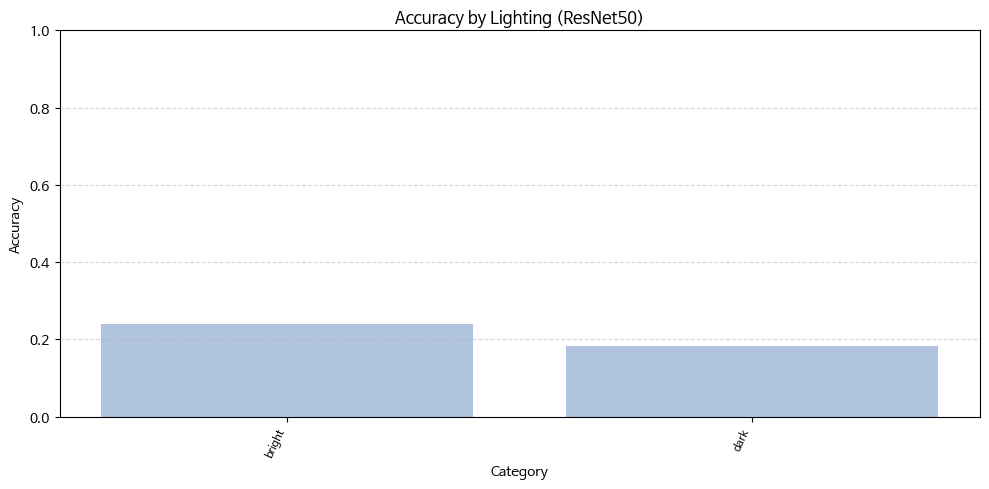

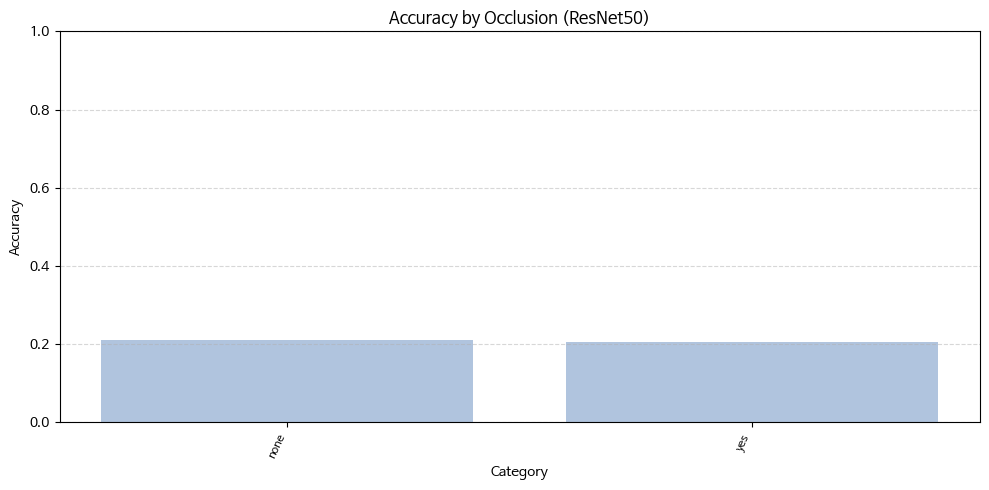

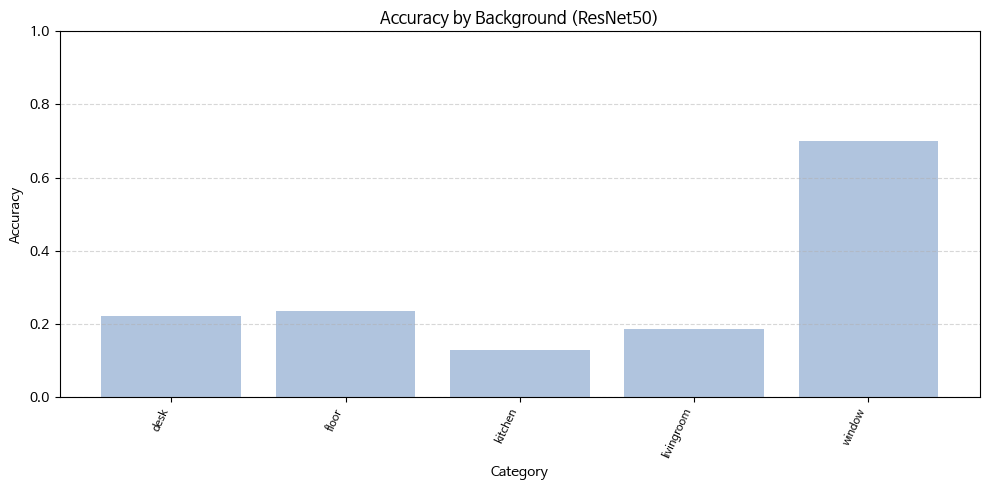

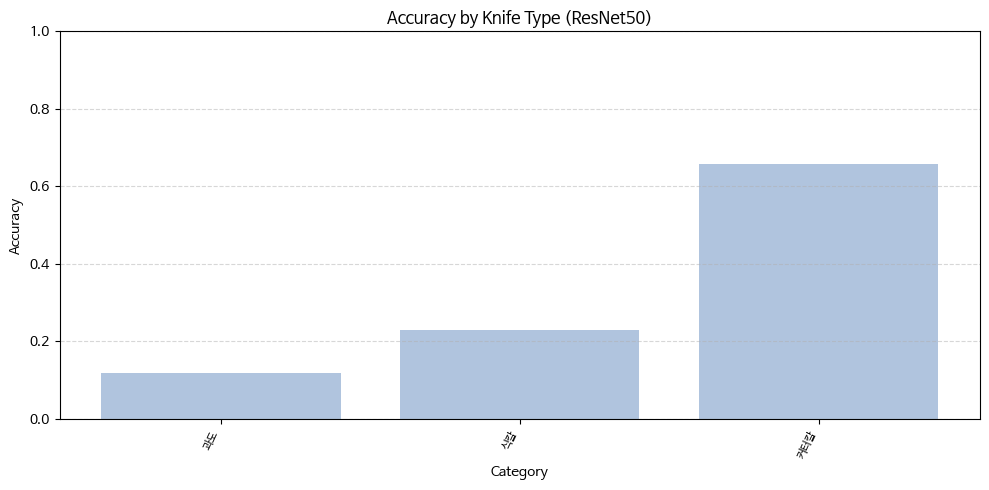

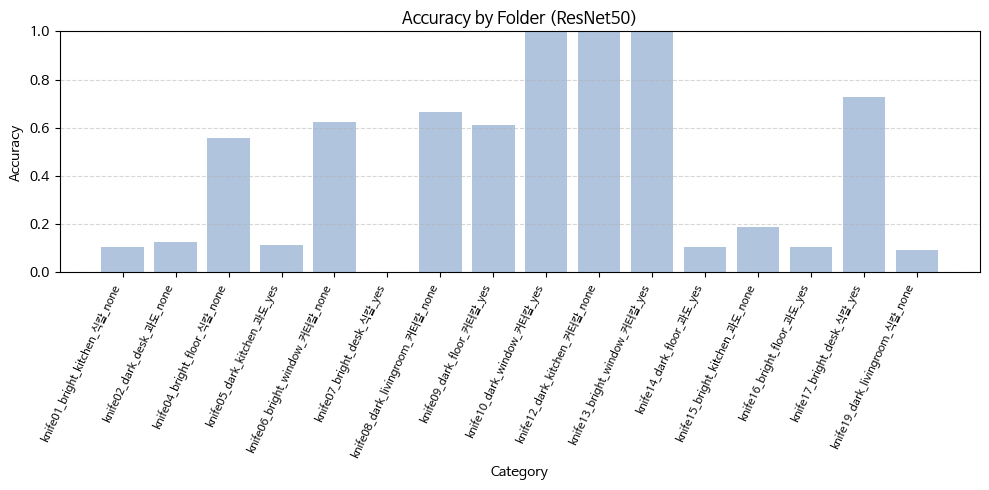

In [ ]:
plt.rc('font', family='NanumBarunGothic')

def plot_accuracy_bar(data, title):
    plt.figure(figsize=(10, 5))
    plt.bar(data.index, data.values, color='lightsteelblue')
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Category")
    plt.xticks(rotation=65, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 각 조건별 시각화
plot_accuracy_bar(조도별정확도, "Accuracy by Lighting (ResNet50)")
plot_accuracy_bar(오클루전정확도, "Accuracy by Occlusion (ResNet50)")
plot_accuracy_bar(배경별정확도, "Accuracy by Background (ResNet50)")
plot_accuracy_bar(칼종류정확도, "Accuracy by Knife Type (ResNet50)")
plot_accuracy_bar(폴더별정확도, "Accuracy by Folder (ResNet50)")


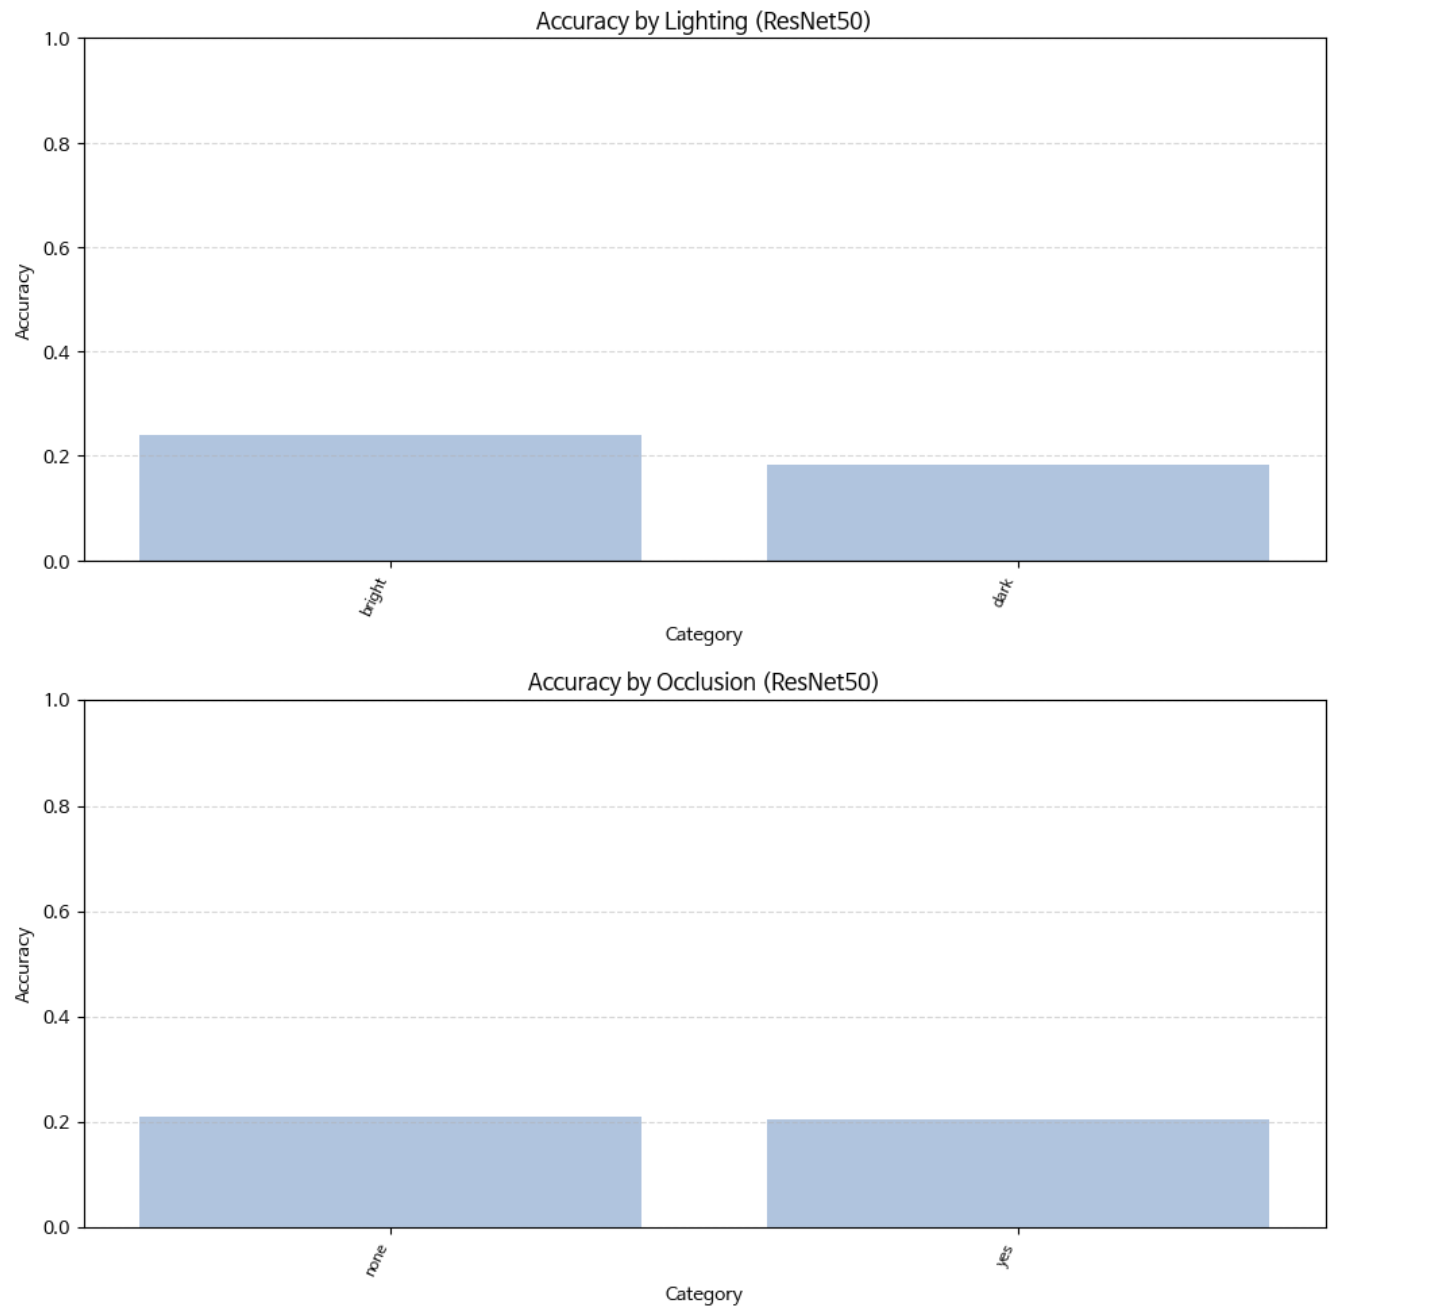

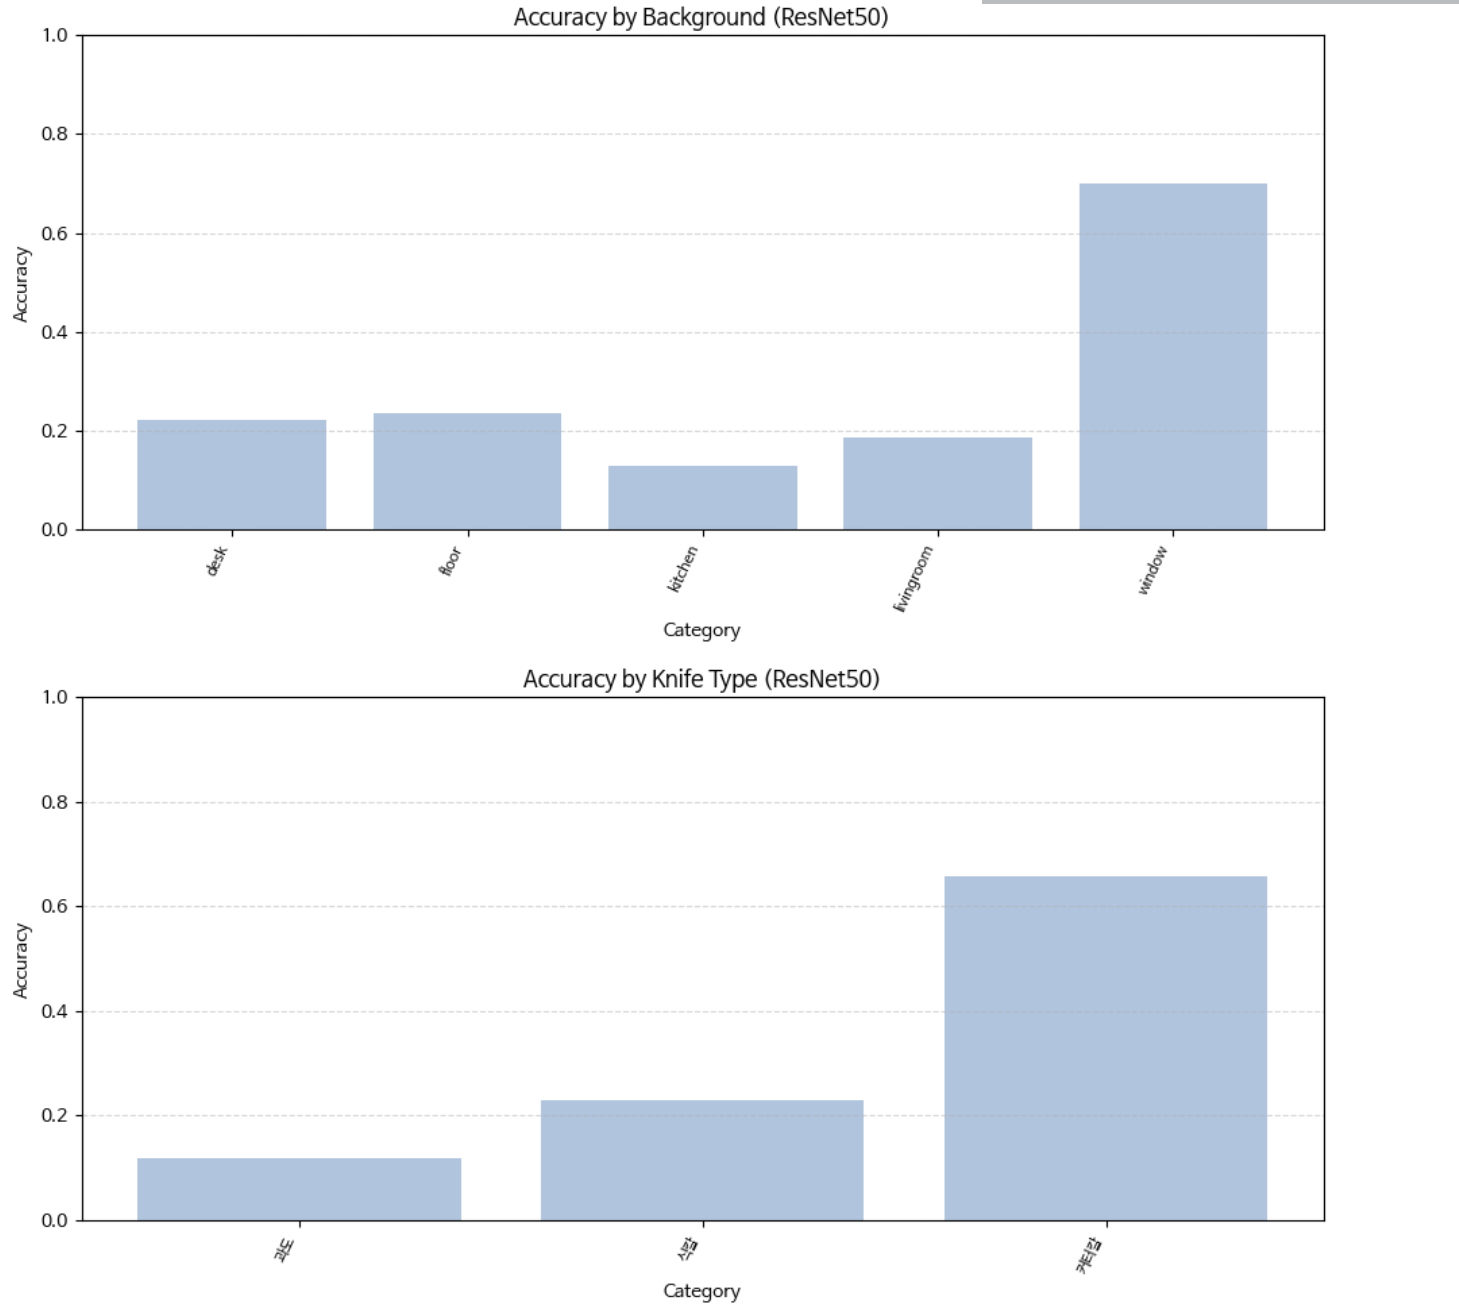
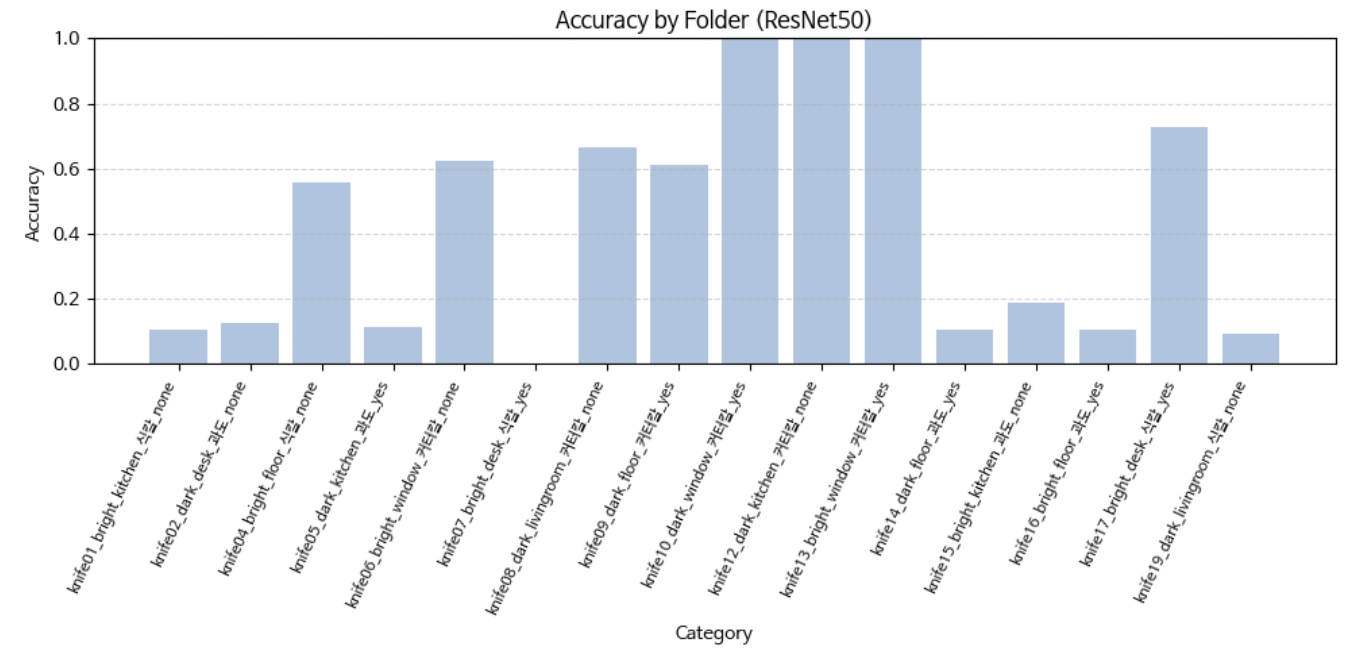

# 조건별 정확도 Bar Plot 해석 요약
1️⃣ 조도별 정확도 (Accuracy by Lighting)

bright: 23.9%, dark: 18.3%
→ 밝은 환경에서 상대적으로 더 높은 정확도를 보였으며, 조도 변화에 민감한 반응을 나타냄

2️⃣ 오클루전 여부별 정확도 (Accuracy by Occlusion)

none: 21.0%, yes: 20.5%
→ 가림 유무에 따른 성능 차이는 거의 없으며, 오클루전 자체는 주요 영향 요인이 아님

3️⃣ 배경별 정확도 (Accuracy by Background)

최고: window(70.0%) / 최저: kitchen(12.8%)
→ 배경에 따라 매우 큰 성능 편차가 발생했으며, 특정 환경(window)에서만 성능이 집중됨

4️⃣ 칼 종류별 정확도 (Accuracy by Knife Type)

커터칼: 65.7%, 식칼: 22.8%, 과도: 11.8%
→ 커터칼에 대해서만 높은 정확도를 보이며, 모델이 특정 클래스에 편향되어 있음

5️⃣ 폴더(조건 조합)별 정확도 (Accuracy by Folder)

최고: knife10-13 (100%) / 최저: knife07, knife19 (09%)
→ 특정 조합에서만 높은 성능을 보이고, 다수 조합에서 성능이 극단적으로 낮아 일관성 부족

[한 줄 요약]
ResNet50은 커터칼과 특정 배경(window)에 과도하게 편향된 예측 경향을 보이며, 전반적으로 데이터 불균형 또는 일반화 부족 문제가 드러났다.


In [ ]:
resnet_df = df_merged.copy()
resnet_df.to_csv("resnet_results.csv", index=False, encoding='cp949')

# ResNet50 최종 요약
ResNet50은 커터칼과 특정 배경(window)에 편향된 예측 경향을 보이며, 특히 식칼과 과도 클래스에서는 분류 실패 수준의 낮은 성능을 보였다. 전체적으로 학습 편향과 일반화 부족 문제가 나타났다.